In [1]:
import sys
import os
sys.path.append("../..")

from progressbar import progressbar as pbar
from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets import RandomIntervalSDOML 
from importlib import reload
from sdofm.models import unet_virtualeve
import torch
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from rlxutils import subplots
import pickle
reload(unet_virtualeve)

<module 'sdofm.models.unet_virtualeve' from '/home/rlx/SDO-FM/notebooks/downstream-virtualeve/../../sdofm/models/unet_virtualeve.py'>

In [2]:
cfg = OmegaConf.load("../../experiments/default.yaml")
cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.eve, cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.cache,

('/mnt/sdoml', 'EVE_legacy.zarr', '/mnt/sdoml', 'cache')

In [3]:
reload(RandomIntervalSDOML)


def get_datamodule(year='2011'):
    year_end = year
    year_start = year
    data_module = RandomIntervalSDOML.RandomIntervalSDOMLDataModule(
        hmi_path=os.path.join(
            cfg.data.sdoml.base_directory,
            cfg.data.sdoml.sub_directory.hmi,
        ),
        aia_path = os.path.join(
            cfg.data.sdoml.base_directory,
            cfg.data.sdoml.sub_directory.aia,
        ),    
        eve_path = os.path.join(
            cfg.data.sdoml.base_directory,
            cfg.data.sdoml.sub_directory.eve,
        ),    
        components  = cfg.data.sdoml.components,
        wavelengths = cfg.data.sdoml.wavelengths,
        ions        = cfg.data.sdoml.ions,
        frequency   = cfg.data.sdoml.frequency,
        batch_size  = 8,
        num_workers = 10,
        num_frames  = 1,
        blosc_cache = "/home/rlx/blosc_cache",
        start_date = f'{year_start}-01-01',
        end_date   = f'{year_end}-12-31',
        dim = False,
        sampling_period = '10days',
        val_months  = cfg.data.month_splits.val,
        test_months = cfg.data.month_splits.test,
        holdout_months = cfg.data.month_splits.holdout,
        cache_dir = os.path.join(
            cfg.data.sdoml.base_directory,
            cfg.data.sdoml.sub_directory.cache,
        ),
    )
    data_module.setup()
    return data_module

In [4]:
pretrained_unet = torch.load("../fm-brightspots/unetmodel_12ch_1classes_bilinear_sizefactor4.ckpt").cuda()

## training loop

In [5]:
#loss_fn = lambda a,b: torch.sqrt( torch.mean((a-b)**2 ) )

huber_loss = torch.nn.HuberLoss()
loss_fn = huber_loss

def loss_from_batch(model, batch, ions_idxs):
    # extract data from batch
    img_stack = batch['image_stack'][:,:,0].cuda()
    target_ions = batch['eve_data'][:,:,0].cuda()[:, ions_idxs]

    # forward
    predicted_ions = model(img_stack)

    # loss
    loss = loss_fn(target_ions, predicted_ions)
    
    return loss

def train_loop(model, optimizer, dataloader, ions_idxs, num_epochs=3):
    lossh = []
    for epoch in range(num_epochs):
        t0 = datetime.now() 

        try:
            for step, batch in enumerate(dataloader):
                # forward and loss
                loss = loss_from_batch(model, batch, ions_idxs = ions_idxs)

                # backpropage and optimzier uipdate
                loss.backward()
                optimizer.step()

                # cosmetics
                lossn = loss.detach().cpu().numpy()
                lossh.append(lossn)

                psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in model.parameters()])    
                lossm = np.mean(lossh[-100:])
                epoch_time = (datetime.now() - t0).seconds
                print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f} epoch_time {epoch_time} secs", end="\r")

        except KeyboardInterrupt:
            print ("\nkeyboard interrupt")
            break
        except Exception as e:
            print (e)
            pass
        print()
    return lossh

def ploth(h, data_module=None, name='loss', ylim=None, ax=None, color='blue'):
    
    if data_module is not None:
        bs = data_module.batch_size
        nchips = len(data_module.train_ds)
        steps_per_epoch = nchips // bs
        for i in range(0,len(h), steps_per_epoch):
            plt.axvline(i, ls='--', color='gray', alpha=.5)

    lossp = pd.DataFrame(h, columns=['signal'])
    lossp[f'smoothed'] = lossp['signal'].rolling(500).mean()
    plt.plot(lossp['signal'], color=color, alpha=.1)
    plt.plot(lossp[f'smoothed'], color=color, alpha=1, label=name)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)
    return lossp

In [8]:
def experiment(year, ions_idxs):
    
    data_module = get_datamodule(year)
    
    confs = {}
    fc_layers_size = [38*2] # [38*10, 19*10]
    learning_rate = 1e-5
    output_size = len(ions_idxs)


    #model= unet_virtualeve.VirtualEVEEstimator(pretrained_unet=pretrained_unet, output_size=output_size, fc_layers_size=fc_layers_size).cuda()
    #confs['unet_pretrained_full'] = {'model': model,
    #                  'optimizer': torch.optim.Adam(model.parameters(), lr=learning_rate)}

    model= unet_virtualeve.VirtualEVEEstimator(pretrained_unet=pretrained_unet, output_size=output_size, fc_layers_size=fc_layers_size).cuda()
    confs['unet_pretrained_fconly'] = {'model': model,
                      'optimizer': torch.optim.Adam(model.fc_layers.parameters(), lr=learning_rate)}

    model= unet_virtualeve.VirtualEVEEstimator(pretrained_unet=None, output_size=output_size, fc_layers_size=fc_layers_size).cuda()
    confs['scratch'] = {'model': model,
                      'optimizer': torch.optim.Adam(model.parameters(), lr=learning_rate)}
    
    
    lossh_models= {}
    num_epochs = 3
    for k in confs.keys():
        print ("-----", k, "------")
        model = confs[k]['model']
        optimizer = confs[k]['optimizer']
        dataloader = data_module.train_dataloader()
        lossh_models[k] = train_loop(model, optimizer, dataloader = data_module.train_dataloader(), ions_idxs=ions_idxs, num_epochs=num_epochs)
        
    return model, lossh_models

In [9]:
model2011, lossh_model2011 = experiment(year='2011', ions_idxs=list(range(38)))


[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_HMI_FULL_AIA_FULL_EVE_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_HMI_FULL_AIA_FULL_EVE_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.
----- unet_pretrained_fconly ------
epoch   0 step 1097 loss 0.12057 params 0.2865015 epoch_time 205 secs
epoch   1 step 1097 loss 0.09418 params 0.2867758 epoch_time 191 secs
epoch   2 step 1097 loss 0.08226 params 0.2871172 epoch_time 198 secs
----- scratch ------
epoch   0 step 1097 loss 0.10589 params 0.2697626 epoch_time 192 secs
epoch   1 step 1097 loss 0.12184 params 0.2714693 epoch_time 199 secs
epoch   2 step 1097 loss 0.08342 params 0.2729449 epoch_time 192 secs


In [10]:
model2012, lossh_model2012 = experiment(year='2012', ions_idxs=list(range(38)))


[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_HMI_FULL_AIA_FULL_EVE_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_HMI_FULL_AIA_FULL_EVE_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.
----- unet_pretrained_fconly ------
epoch   0 step 1104 loss 0.12130 params 0.2866991 epoch_time 194 secs
epoch   1 step 1104 loss 0.08990 params 0.2870095 epoch_time 192 secs
epoch   2 step 1104 loss 0.07887 params 0.2873333 epoch_time 193 secs
----- scratch ------
epoch   0 step 1104 loss 0.12565 params 0.2714305 epoch_time 193 secs
epoch   1 step 1104 loss 0.09110 params 0.2731229 epoch_time 194 secs
epoch   2 step 1104 loss 0.08878 params 0.2750877 epoch_time 193 secs


In [13]:
model2013, lossh_model2013 = experiment(year='2013', ions_idxs=list(range(38)))

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_HMI_FULL_AIA_FULL_EVE_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_HMI_FULL_AIA_FULL_EVE_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.
----- unet_pretrained_fconly ------
epoch   0 step 755 loss 0.11705 params 0.2862753 epoch_time 130 secs
epoch   1 step 755 loss 0.09909 params 0.2864104 epoch_time 130 secs
epoch   2 step 755 loss 0.09182 params 0.2865821 epoch_time 129 secs
----- scratch ------
epoch   0 step 755 loss 0.11038 params 0.2712771 epoch_time 129 secs
epoch   1 step 755 loss 0.10600 params 0.2722414 epoch_time 129 secs
epoch   2 step 755 loss 0.09553 params 0.2733630 epoch_time 128 secs


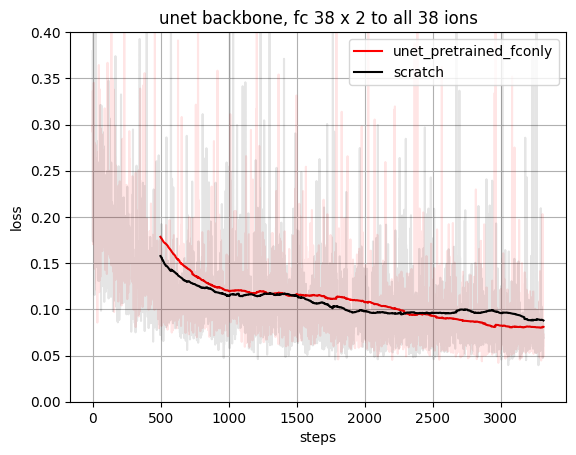

In [18]:
colors = {'unet_pretrained_fconly': 'red', 
          'scratch': 'black'}
lh = lossh_model2012
for name in lh.keys():
    pp = ploth(lh[name][:1097*5], data_module = None, name=name, color=colors[name])
plt.grid();
plt.title("unet backbone, fc 38 x 2 to all 38 ions")
plt.ylim(0,0.4)
plt.legend()

In [19]:
data_module = get_datamodule('2011')


[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_HMI_FULL_AIA_FULL_EVE_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_HMI_FULL_AIA_FULL_EVE_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [60]:
testdl = data_module.train_dataloader()

In [61]:
yts, predts = [], []
ions_idxs = list(range(38))
for batch in pbar(testdl):
    img_stack = batch['image_stack'][:,:,0].cuda()
    target_ions = batch['eve_data'][:,:,0].cpu()[:, ions_idxs]

    # forward
    predicted_ions = model2011(img_stack).detach().cpu().numpy()
    
    for i in range(len(predicted_ions)):
        yts.append(target_ions[i].numpy())
        predts.append(predicted_ions[i])
        
        

100% (1098 of 1098) |####################| Elapsed Time: 0:02:25 Time:  0:02:250111


In [62]:
predts = np.r_[predts]
yts = np.r_[yts]

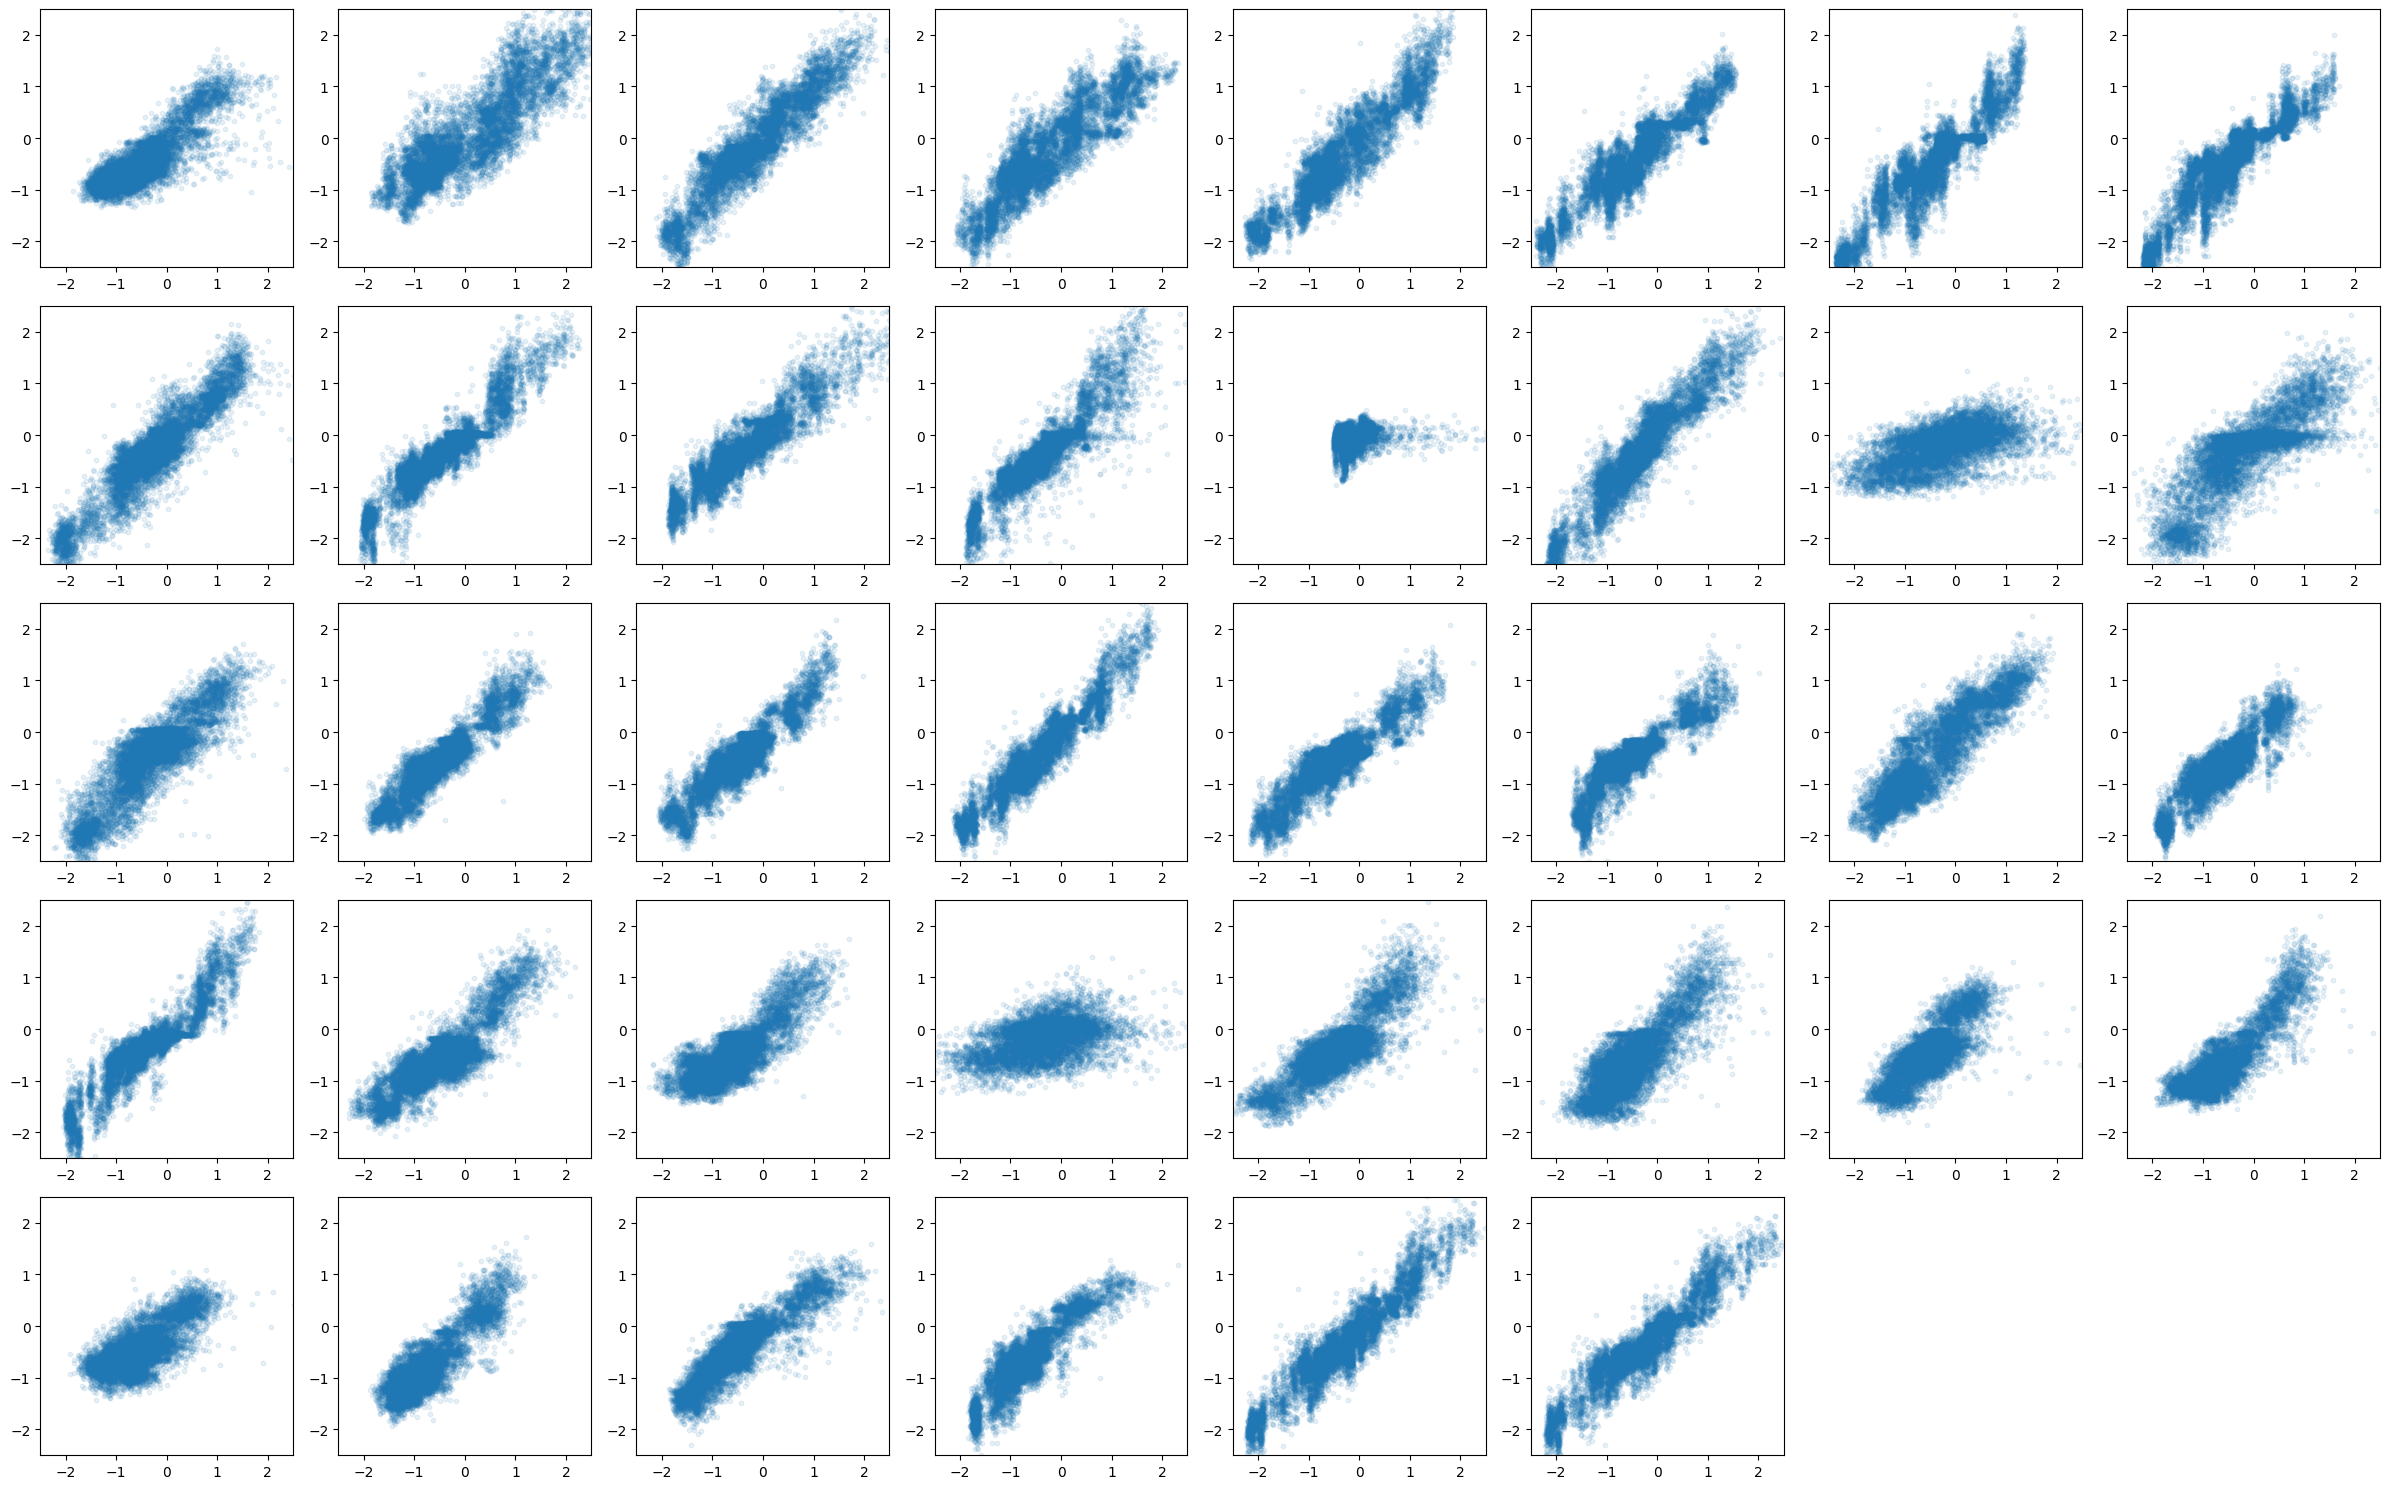

In [63]:
idx = 3
for ax,idx in subplots(38, n_cols=8):
    plt.scatter(yts[:,idx], predts[:,idx], s=10, alpha=.1)
    plt.xlim(-2.5,2.5)
    plt.ylim(-2.5,2.5)


In [47]:
yts - predts

array([[1.2793157, 2.0629702, 1.9108568, ..., 1.1392131, 2.0222387,
        2.2335768],
       [1.3935591, 1.9658315, 1.8709574, ..., 1.236788 , 1.9557414,
        2.1873438],
       [1.1361507, 1.9480376, 1.7765489, ..., 1.2157654, 1.9726951,
        2.2365596],
       ...,
       [1.4122212, 1.7240093, 1.6067055, ..., 1.2907459, 1.5884675,
        1.7920902],
       [1.2941424, 1.7668355, 1.640127 , ..., 1.3010206, 1.5927124,
        1.7703196],
       [1.342231 , 1.6395006, 1.549353 , ..., 1.4091161, 1.5903422,
        1.7722924]], dtype=float32)

# train model per ion

In [21]:
year = '2011'
for ion_idx in list(range(0,38)):
    print (f"------\n {year} ion {ion_idx} \n-------")
    loss_fname = f"{year}_ion{ion_idx}.pkl"
    
    if os.path.isfile(loss_fname):
        print ("already done.")
        continue
    
    lossh_models = experiment(year=year, ions_idxs=[ion_idx])
    
    with open(loss_fname, "wb") as f:
        pickle.dump(lossh_models, f)

------
 2011 ion 0 
-------
already done.
------
 2011 ion 1 
-------
already done.
------
 2011 ion 2 
-------
already done.
------
 2011 ion 3 
-------
already done.
------
 2011 ion 4 
-------
already done.
------
 2011 ion 5 
-------
already done.
------
 2011 ion 6 
-------
already done.
------
 2011 ion 7 
-------
already done.
------
 2011 ion 8 
-------
already done.
------
 2011 ion 9 
-------
already done.
------
 2011 ion 10 
-------
already done.
------
 2011 ion 11 
-------
already done.
------
 2011 ion 12 
-------
already done.
------
 2011 ion 13 
-------
already done.
------
 2011 ion 14 
-------
already done.
------
 2011 ion 15 
-------
already done.
------
 2011 ion 16 
-------
already done.
------
 2011 ion 17 
-------
already done.
------
 2011 ion 18 
-------
already done.
------
 2011 ion 19 
-------
[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_HMI_FULL_AIA_FULL_EVE_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in

In [ ]:
year = '2011'
for ion_idx in range(4,38):
    print (f"------\n {year} ion {ion_idx} \n-------")
    experiment(year=year, ions_idxs=[ion_idx])
    
    loss_fname = f"{year}_ion{ion_idx}.pkl"
    with open(loss_fname, "wb") as f:
        pickle.dump(lossh_models, f)

------
 2011 ion 4 
-------
[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_HMI_FULL_AIA_FULL_EVE_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_HMI_FULL_AIA_FULL_EVE_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.
----- scratch ------
epoch   0 step 1097 loss 0.13180 params 0.2759212 epoch_time 195 secs
epoch   1 step 1097 loss 0.08657 params 0.2773540 epoch_time 347 secs
epoch   2 step 1097 loss 0.07372 params 0.2789696 epoch_time 426 secs
epoch   3 step 1097 loss 0.04965 params 0.2807982 epoch_time 389 secs
epoch   4 step 1097 loss 0.04469 params 0.2829831 epoch_time 435 secs
----- unet_pretrained_fconly ------
epoch   0 step 1097 loss 0.22371 params 0.2911030 epoch_time 432 secs
epoch   1 step 1097 loss 0.15805 params 0.2913535 epoch_time 421 secs
epoch   2 step 1097 loss 0.10992 params 0.2917179 epoch_time 436 secs
epoch   3 step 1097 loss 0.0773

In [17]:
#torch.save(confs['scratch']['model'], "unet_dim_scratch.ckpt")

In [24]:
lossh_models.keys()

dict_keys(['scratch', 'unet_pretrained_fconly'])

(0.0, 0.5)

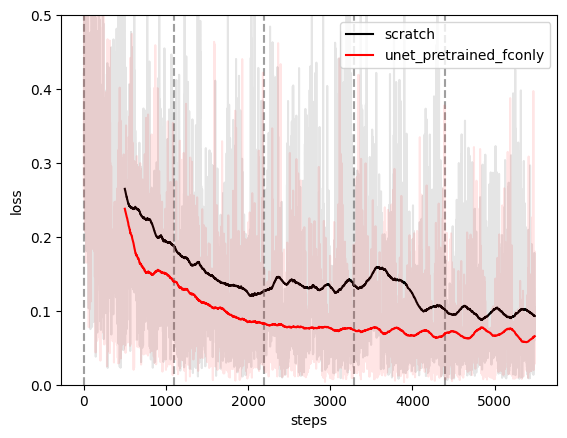

In [25]:
for name,color in zip( confs.keys(), ('black', 'red', 'blue')):
    pp = ploth(lossh_models[name], data_module = data_module, name=name, color=color)
plt.legend()
plt.ylim(0,0.5)

(0.0, 0.5)

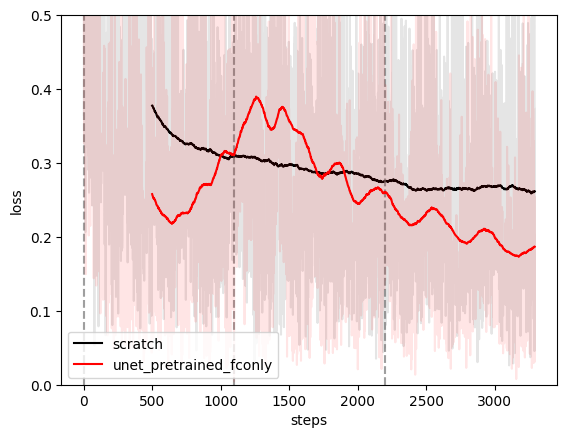

In [17]:
for name,color in zip( confs.keys(), ('black', 'red', 'blue')):
    pp = ploth(lossh_models[name], data_module = data_module, name=name, color=color)
plt.legend()
plt.ylim(0,0.5)

(0.0, 0.2)

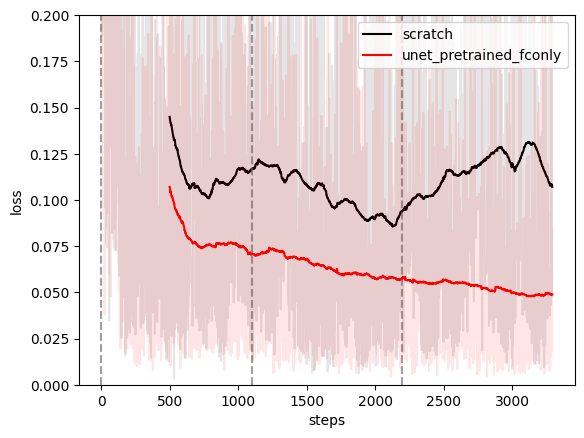

In [73]:
for name,color in zip( confs.keys(), ('black', 'red', 'blue')):
    pp = ploth(lossh_models[name], data_module = data_module, name=name, color=color)
plt.legend()
plt.ylim(0,0.2)

In [26]:
def get_predictions(models, dataloader):
    
    targets = []
    predictions = {k:[] for k in models.keys()}
    
    for batch in pbar(dataloader):

        # extract data from batch
        img_stack = batch['image_stack'][:,:,0].cuda()
        target_ions = batch['eve_data'][:,:,0].cuda()

        # forward
        predicted_ions = {k:model(img_stack).detach().cpu().numpy() for k,model in models.items()}
        
        for t in target_ions.cpu().numpy():
            targets.append(t)
            
        for k in models.keys():
            for p in predicted_ions[k]:
                predictions[k].append(p)
        
    predictions = {k:np.r_[v] for k,v in predictions.items()}
    targets = np.r_[targets]
        
    return targets, predictions



In [27]:
tr_targets, tr_preds = get_predictions({k:confs[k]['model'] for k in confs.keys()}, data_module.train_dataloader())

100% (3302 of 3302) |####################| Elapsed Time: 0:16:14 Time:  0:16:140823


In [ ]:
val_targets, val_preds = get_predictions({k:confs[k]['model'] for k in confs.keys()}, data_module.val_dataloader())

100% (260 of 260) |######################| Elapsed Time: 0:41:50 Time:  0:41:502915


In [29]:
tr_targets.shape, tr_preds['scratch'].shape

((26416, 38), (26416, 1))

In [30]:
loss_fn

HuberLoss()

In [31]:
{'train loss':
     {k: float(loss_fn(torch.Tensor(tr_targets), torch.Tensor(tr_preds[k])).numpy()) for k in tr_preds.keys()},
 'val_loss':
     {k: float(loss_fn(torch.Tensor(val_targets), torch.Tensor(val_preds[k])).numpy()) for k in val_preds.keys()}
}

/opt/conda/envs/sdofm/lib/python3.10/site-packages/torch/nn/modules/loss.py:993: UserWarning: Using a target size (torch.Size([26416, 1])) that is different to the input size (torch.Size([26416, 38])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/opt/conda/envs/sdofm/lib/python3.10/site-packages/torch/nn/modules/loss.py:993: UserWarning: Using a target size (torch.Size([2079, 1])) that is different to the input size (torch.Size([2079, 38])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


{'train loss': {'scratch': 0.15113984048366547,
  'unet_pretrained_fconly': 0.13888248801231384},
 'val_loss': {'scratch': 0.3135073184967041,
  'unet_pretrained_fconly': 0.3813496530056}}

scratch
unet_pretrained_fconly


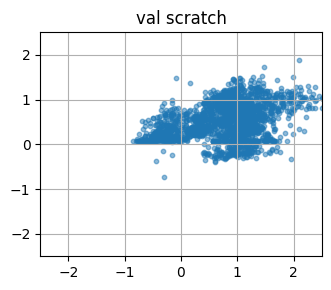

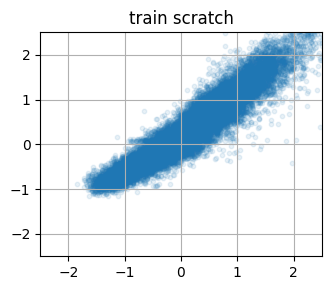

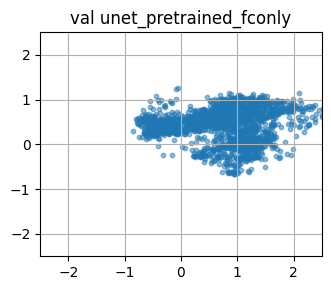

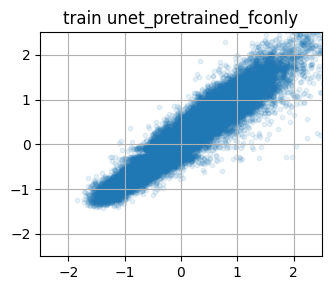

In [32]:
for k in tr_preds.keys():
    print (k, flush=True)
    for ax,i in subplots(val_preds[k].shape[1], n_cols=13):
        if i==0: plt.title(f"val {k}")
        plt.scatter(val_targets[:,i], val_preds[k][:,i], s=10, alpha=.5)
        plt.grid()
        plt.xlim(-2.5,2.5)
        plt.ylim(-2.5,2.5)

    for ax,i in subplots(tr_preds[k].shape[1], n_cols=13):
        if i==0: plt.title(f"train {k}")
        plt.scatter(tr_targets[:,i], tr_preds[k][:,i], s=10, alpha=.1)
        plt.grid()
        plt.xlim(-2.5,2.5)
        plt.ylim(-2.5,2.5)

In [82]:
val_preds[k].shape

(519, 1)